In [7]:
import json
import os
import sys

import geopandas as gpd
import shapely.geometry as geom

# Re-use some of the libraries that are used by app
sys.path.append('../apps/arcade-pipeline')
sys.path.append('../apps/arcade-pipeline/utils')

from tiff_image_processor import write_to_tif, create_tif_file_metadata
from stac_catalog_processor import STACCatalogProcessor, EngineProcessRequest

## Set with your environment specific value

In [1]:
%env AWS_ACCESS_KEY_ID=
%env AWS_SECRET_ACCESS_KEY=
%env AWS_SESSION_TOKEN=
%env STAC_CATALOG_OUTPUT_BUCKET=
%env ARCADE_EVENT_BUS_NAME=
%env ARCADE_STAC_SERVER_URL=
%env AWS_BATCH_JOB_ID=

env: AWS_ACCESS_KEY_ID=
env: AWS_SECRET_ACCESS_KEY=
env: AWS_SESSION_TOKEN=
env: STAC_CATALOG_OUTPUT_BUCKET=
env: ARCADE_EVENT_BUS_NAME=
env: ARCADE_STAC_SERVER_URL=
env: AWS_BATCH_JOB_ID=


In [8]:
input_json_string = "{\"groupId\":\"01hwcek1f2t31r99qa4xs74skx\",\"regionId\":\"01hwcet7zyhy0xe31mmfwh6qgk\",\"zoneId\":\"01hwcf5s2s1h49jpf8s58qhrkb\",\"stateId\":\"01hwcg1qfy5d8apvtncxn3rnxq\",\"scheduleDateTime\":\"2023-08-30\",\"coordinates\":[[-104.5079674,39.9194752],[-104.4894065,39.9193435],[-104.4893912,39.9122295],[-104.5078877,39.9123941]]}"

## Load the StacCatalogProcessor (same module used by the container)

In [9]:
request = EngineProcessRequest.from_dict(json.loads(input_json_string))
processor = STACCatalogProcessor(request)
processor.search_stac_items()

# TODO: this need to be populated by querying the state rest api
yield_target = 20
crop = 'wheat'
planted_at = '2024-04-01'


Found: 2 items


## Publish start event

In [4]:
import boto3

event_bus_name = os.getenv("ARCADE_EVENT_BUS_NAME")
job_id = os.getenv('AWS_BATCH_JOB_ID')

# Create an EventBridge client
eventbridge = boto3.client('events')

# Define the event details
event = {
	'EventBusName': event_bus_name,
	'Source': 'com.aws.arcade.engine',
	'DetailType': 'com.aws.arcade>results>started',
	'Detail': json.dumps({
		"groupId": request.group_id,
		"zoneId": request.zone_id,
		"regionId": request.region_id,
		"schedule": request.schedule_date_time,
		"jobId": job_id,
	}),
}

# Publish the event to EventBridge
response = eventbridge.put_events(
	Entries=[
		{
			'Source': event['Source'],
			'DetailType': event['DetailType'],
			'Detail': event['Detail']
		}
	]
)

print(response)

NameError: name 'os' is not defined

## Plot Region (Debugging)

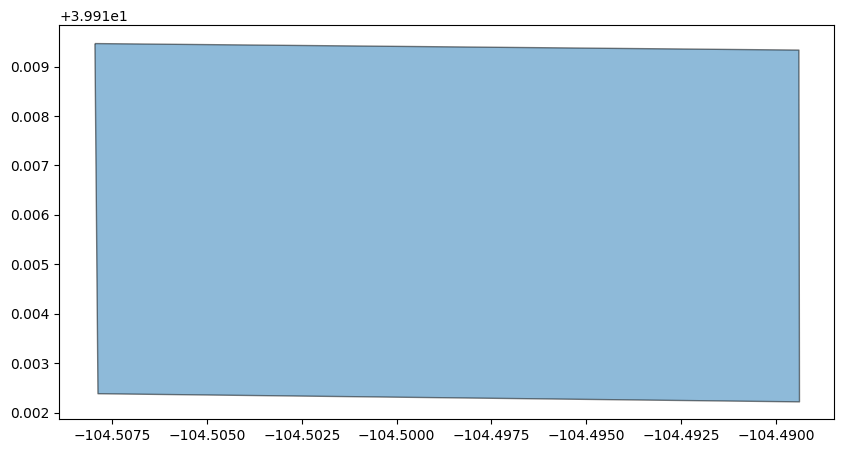

In [10]:
CRS = 'epsg:4326'
zone = geom.Polygon(request.coordinates)
zone_array = [zone]
zone_series = gpd.GeoSeries(zone_array, crs=CRS)
aoi = gpd.GeoDataFrame(geometry=zone_series, crs=CRS)
aoi.plot(figsize=(10, 8), alpha=0.5, edgecolor='k')
bounding_box = zone_series.total_bounds

## Initialise metadata.json

In [11]:
output_metadata = {
	"bounding_box": bounding_box.tolist(),
	"geometry": {
		'type': 'Polygon',
		'coordinates': request.coordinates
	},
	"properties": {},
	"links": [{"rel": "derived_from", "href": link.href, "type": link.media_type} for link in processor.stac_item.links if link.rel == 'self'].pop(),
	"assets": {}
}

## 1. Calculate all the default bands

In [12]:
stac_assets = processor.calculate_bands_from_stac_item()

## 2. Calculate cloud removal bands

In [13]:
# Perform cloud removal
stac_assets = processor.calculate_cloud_removal_band(stac_assets)

## Plot after cloud removal (debugging)

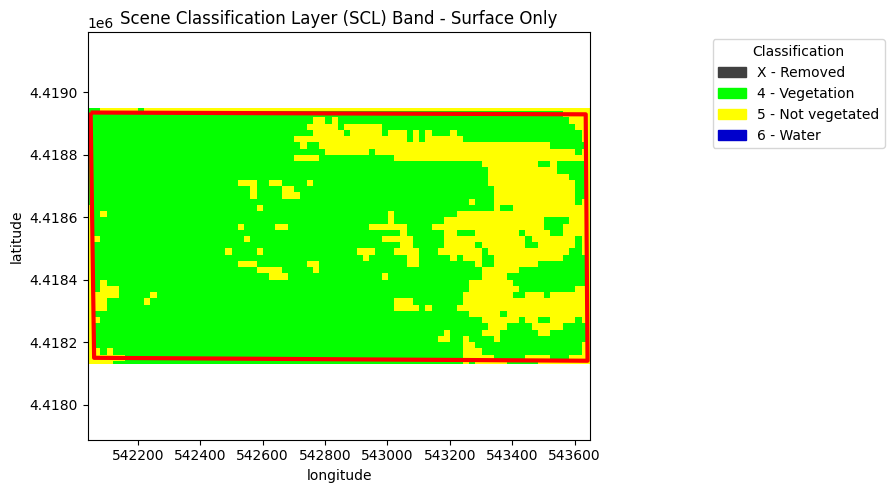

In [14]:
from pystac.extensions.projection import ProjectionExtension
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pyproj import CRS

sentinel_epsg = ProjectionExtension.ext(processor.stac_item).epsg
output_crs = CRS.from_epsg(sentinel_epsg)

aoi_projected = aoi.to_crs(output_crs)

scl_color_def = [
	(0, '#000000', 'No data'),  # black
	(1, '#ff0000', 'Saturated or defective'),  # red
	(2, '#404040', 'Cast shadows'),  # gray
	(3, '#833c0b', 'Cloud shadows'),  # brown
	(4, '#04ff00', 'Vegetation'),  # green
	(5, '#ffff00', 'Not vegetated (bare soil)'),  # yellow
	(6, '#0000cc', 'Water'),  # blue
	(7, '#757171', 'Unclassified'),  # medium gray
	(8, '#aeaaaa', 'Cloud medium probability'),  # light gray
	(9, '#d0cece', 'cloud high probability'),  # very light gray
	(10, '#00ccff', 'Thin cirrus'),  # light blue/purple
	(11, '#ff66ff', 'Snow or ice'),  # cyan
]
scl_color_hex = [x[1] for x in scl_color_def]
_ = (
	# cloud_removed.isel(time=0)	# return new xarray.DataSet with each array index along the `time` dimension
	stac_assets[['scl_cloud_removed']]
	.isel(time=0)  # return new xarray.DataSet with each array index along the `time` dimension
	.to_array("band")  # convert to xarray.DataArray
	.plot.imshow(  # wraps matplotlib.pyplot.imshow()
		col="band",  # make column faceted plots on this dimension name
		size=5,  # height (in inches) of each plot.
		vmin=0,  # Lower value to anchor the colormap
		vmax=11,  # Upper value to anchor the colormap
		colors=scl_color_hex,
		levels=13,
		add_colorbar=False)
)

plt.title("Scene Classification Layer (SCL) Band - Surface Only")
plt.xlabel("longitude")
plt.ylabel("latitude")

ax = plt.gca()
ax.axis("equal")

# Create a legend object and add the patches to it
masked_color_def = [
	('X', '#404040', 'Removed'),
	(4, '#04ff00', 'Vegetation'),  # green
	(5, '#ffff00', 'Not vegetated'),  # yellow
	(6, '#0000cc', 'Water')  # blue
]
patches = []
for color in masked_color_def:
	patch = mpatches.Patch(color=color[1], label='{} - {}'.format(color[0], color[2]))
	patches.append(patch)
plt.legend(handles=patches, title='Classification', bbox_to_anchor=(1.6, 1))

# add the zone boundaries
_ = aoi_projected.plot(ax=ax, facecolor="none", edgecolor='red', lw=3)

## 3. Calculate ndvi raw

In [15]:
stac_assets = processor.calculate_ndvi_raw_band(stac_assets)
# Print out the first element of the ndvi multi dimension array
print(stac_assets['ndvi_raw'].values.flatten()[0])

0.42088447956953084


## 4. Calculate zone area

In [16]:
area_acres = processor.calculate_area()
# Set the area metadata
output_metadata['properties']['area_size'] = area_acres
output_metadata['properties']['area_unit_of_measure'] = 'acres'
output_metadata['properties']['crop_type'] = crop
output_metadata['properties']['crop_planted_at'] = planted_at
print(area_acres)

525.0086725299224


## 5. Fill cloud gap

In [17]:
stac_assets = processor.fill_cloud_gap(stac_assets)

no cloud gap


## 6. Calculate ndvi change

In [18]:
# We only perform change detection when previous NDVI data is available
stac_assets = processor.calculate_ndvi_change(stac_assets)

## 7. Calculate nitrogen recommendation

In [19]:
from tiff_image_processor import calculate_checksum

bucket_name = os.getenv("STAC_CATALOG_OUTPUT_BUCKET")
s3_prefix = 's3://{}/{}/{}/{}/{}'.format(bucket_name, request.group_id, request.region_id, request.zone_id, request.schedule_date_time)

# Calculate nitrogen recommendation target based on yield target
calculated_nitrogen_target = yield_target * 0.8 * area_acres

nitrogen_recommendation = processor.calculate_nitrogen_recommendation(yield_target, area_acres)

nitrogen_file_path = "output/nitrogen.json"

with open(nitrogen_file_path, "w") as file:
	# Write content to the file
	file.write(json.dumps(nitrogen_recommendation))

checksum_algorithm = "md5"

output_metadata['assets']['nitrogen_metadata'] = {
	"href": "s3://{}/{}/nitrogen.json".format(bucket_name, s3_prefix),
	"type": "application/json",
	"file:checksum": calculate_checksum(nitrogen_file_path, checksum_algorithm),
	"file:size": os.path.getsize(nitrogen_file_path),
	"roles": [
		"metadata"
	]
}

print(output_metadata)


{'bounding_box': [-104.5079674, 39.9122295, -104.4893912, 39.9194752], 'geometry': {'type': 'Polygon', 'coordinates': [(-104.5079674, 39.9194752), (-104.4894065, 39.9193435), (-104.4893912, 39.9122295), (-104.5078877, 39.9123941)]}, 'properties': {'area_size': 525.0086725299224, 'area_unit_of_measure': 'acres', 'crop_type': 'wheat', 'crop_planted_at': '2024-04-01'}, 'links': {'rel': 'derived_from', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-c1-l2a/items/S2A_T13TEE_20230829T175555_L2A', 'type': 'application/geo+json'}, 'assets': {'nitrogen_metadata': {'href': 's3:///s3:///01hwcek1f2t31r99qa4xs74skx/01hwcet7zyhy0xe31mmfwh6qgk/01hwcf5s2s1h49jpf8s58qhrkb/2023-08-30/nitrogen.json', 'type': 'application/json', 'file:checksum': '69fe70a633564e69aeb263ac11566939', 'file:size': 186, 'roles': ['metadata']}}}


## Generate tif images and band(s) metadata 

In [20]:
temp_dir = "{}/{}".format(os.getcwd(), "output")

band_file_paths = write_to_tif(temp_dir, stac_assets, 'images', ['red', 'green', 'blue', 'scl', 'nir08', 'ndvi', 'ndvi_raw', 'scl_cloud_removed', 'ndvi_change'])
band_assets = create_tif_file_metadata(stac_assets, band_file_paths, "{}/{}".format(s3_prefix, "images"), checksum_algorithm)
print(band_assets)
output_metadata['assets'] = {**output_metadata['assets'], **band_assets}

{'red': {'href': 's3:///01hwcek1f2t31r99qa4xs74skx/01hwcet7zyhy0xe31mmfwh6qgk/01hwcf5s2s1h49jpf8s58qhrkb/2023-08-30/images/red.tif', 'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'title': 'red', 'file:checksum': '0287d478c4968bd33867820f598aaaab', 'file:size': 26912, 'roles': ['data', 'reflectance']}, 'green': {'href': 's3:///01hwcek1f2t31r99qa4xs74skx/01hwcet7zyhy0xe31mmfwh6qgk/01hwcf5s2s1h49jpf8s58qhrkb/2023-08-30/images/green.tif', 'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'title': 'green', 'file:checksum': '0234cad744aacf5ee5dc624796c22acf', 'file:size': 26914, 'roles': ['data', 'reflectance']}, 'blue': {'href': 's3:///01hwcek1f2t31r99qa4xs74skx/01hwcet7zyhy0xe31mmfwh6qgk/01hwcf5s2s1h49jpf8s58qhrkb/2023-08-30/images/blue.tif', 'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'title': 'blue', 'file:checksum': '42afd3ac8b703fbe4d2c39d8f0610df0', 'file:size': 26914, 'roles': ['data', 'reflectance']}, 'scl': {'href': 's

## Generate metadata.json

In [ ]:
with open("output/metadata.json", "w") as file:
	# Write content to the file
	file.write(json.dumps(output_metadata))


## Upload artifacts to S3

In [ ]:
import boto3
import os

# Create an S3 client
s3 = boto3.client('s3')

for root, dirs, files in os.walk(temp_dir):
	s3_key_prefix = '{}/{}/{}/{}'.format(request.group_id, request.region_id, request.zone_id, request.schedule_date_time)
	for file in files:
		# Construct the full file path
		file_path = os.path.join(root, file)
		# Construct the key (file path in S3)
		key = os.path.relpath(file_path, temp_dir)
		# Upload the file to S3
		s3.upload_file(file_path, bucket_name, "{}/{}".format(s3_key_prefix, key))
		print(f'Uploaded {file_path} to {s3_prefix}/{key}')

## Publish finish event

In [ ]:
# Define the event details
event = {
	'EventBusName': event_bus_name,
	'Source': 'com.aws.arcade.engine',
	'DetailType': 'arcade>engine>pipeline>finish',
	'Detail': json.dumps({
		"executionId": "execution1234",
		"groupId": request.group_id,
		"zoneId": request.zone_id,
		"regionId": request.region_id,
		"stateId": request.state_id,
		"createdAt": request.schedule_date_time,
		"jobArn": job_id,
		"engineOutPutLocation": f'{s3_prefix}/metadata.json'
	}),
}

print(event)

# Publish the event to EventBridge
response = eventbridge.put_events(
	Entries=[
		{
			'Source': event['Source'],
			'DetailType': event['DetailType'],
			'Detail': event['Detail']
		}
	]
)

print(response)